# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- scipy: https://scipy.org/install/
- gymnasium: https://github.com/Farama-Foundation/Gymnasium (**New package to install**)
    - To install the base Gymnasium library, use **pip install gymnasium**

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import gymnasium as gym

In [38]:
"""Plot function similar to Ex1"""
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.legend(handles=h_list)
    plt.show()

# Q2: Backjack 

Please note, since there is no scaffolding code for this question. Please make sure your implementation is well-tested and the comments are clear to understand. 

In [4]:
# test code for using the "Backjack" implementation from OpenAI
env = gym.make("Blackjack-v1")
env.reset()

# iteracting with the environment for 10 time steps using a random policy
for t in range(10): 
    # sample an random action
    action = env.action_space.sample()
    
    # interact with the envrionment
    next_s, reward, done, info, _ = env.step(action)
    
    # print info
    print(f"t = {t}, next_state = {next_s}, reward = {reward}, done = {done}")
    
    # check termination
    if done:
        env.reset()

t = 0, next_state = (14, 1, 0), reward = -1.0, done = True
t = 1, next_state = (19, 2, 0), reward = 1.0, done = True
t = 2, next_state = (14, 3, 0), reward = 0.0, done = False
t = 3, next_state = (16, 3, 0), reward = 0.0, done = False
t = 4, next_state = (16, 3, 0), reward = 1.0, done = True
t = 5, next_state = (17, 8, 0), reward = 0.0, done = True
t = 6, next_state = (26, 3, 0), reward = -1.0, done = True
t = 7, next_state = (25, 4, 0), reward = -1.0, done = True
t = 8, next_state = (20, 10, 0), reward = 0.0, done = False
t = 9, next_state = (21, 10, 0), reward = 0.0, done = False


## (a): Implement first-visit Monte-Carlo policy evaluation (See pseudocode in 5.1). 

Please read Example 5.1 and reproduce Figure 1. The policy to be evaluated is the "sticks only on 20 or 21". Please only reproduce the plots after 500, 000 episodes (Usable ace and No usable ace). 

In [42]:
def mc_policy_evaluation(env, policy, num_episodes, gamma=1.0):
    """
    First-visit Monte Carlo policy evaluation.
    """
    V = {}  # Initialize value function V(s)
    Returns = {}  # Dictionary to store returns for each state

    for _ in range(num_episodes):  # Loop over episodes
        episode = []  # Store (state, action, reward) for each step of episode
        state = env.reset()[0] # Reset environment and get initial state
        done = False
        while not done:  # Generate an episode
            action = policy(state)  # Get action from policy
            next_state, reward, done, _, _ = env.step(action) # Take a step in the environment
            episode.append((state, action, reward)) # Store the experience
            state = next_state  # Update current state

        G = 0  # Initialize return
        first_visit = set() # Keep track of first visits to each state
        for t in reversed(range(len(episode))):  # Loop backwards through episode steps
            state, _, reward = episode[t] 
            G = gamma * G + reward # Calculate discounted return

            if state not in first_visit:  # Check for first visit
                first_visit.add(state)  # Add the state as visited
                if state not in Returns: # If the state has no returns, make a new list to store its returns
                    Returns[state] = [] 
                Returns[state].append(G) # Append the return
                V[state] = np.mean(Returns[state]) # Update Value function: Average returns for the state

    return V # Return the estimated Value function

In [43]:
def blackjack_policy(state):
    """Sticks only on 20 or 21."""
    score, _, _ = state
    return 0 if score >= 20 else 1  # 0: STICK, 1: HIT

In [77]:
def plot_blackjack_value_function_3d(V, title, num_episodes):
    """Plots correct value function as a 3D wireframe, separate plots for usable/no usable ace."""

    fig = plt.figure(figsize=(12, 7))
    fig.suptitle(f"{title} (After {num_episodes} episodes)", fontsize=16)

    x_range = np.arange(12, 22)  # Player sum
    y_range = np.arange(1, 11)   # Dealer showing
    X, Y = np.meshgrid(y_range, x_range) 

    # Usable Ace subplot
    ax1 = fig.add_subplot(121, projection='3d')
    usable_ace_values = np.zeros((len(x_range), len(y_range)))
    for i, player_sum in enumerate(x_range):
        for j, dealer_showing in enumerate(y_range):
            usable_ace_values[i, j] = V.get((player_sum, dealer_showing, True), 0)
    ax1.plot_wireframe(Y, X, usable_ace_values, label="Usable Ace")
    ax1.set_title("Usable Ace")
    ax1.set_ylabel("Dealer Showing")
    ax1.set_xlabel("Player Sum")
    ax1.set_zlabel("Value")
    ax1.set_yticks(y_range)
    ax1.set_xticks(x_range)
    ax1.view_init(25, 210) # Same viewing angle for consistency

    # No Usable Ace subplot
    ax2 = fig.add_subplot(122, projection='3d')
    no_usable_ace_values = np.zeros((len(x_range), len(y_range)))
    for i, player_sum in enumerate(x_range):
        for j, dealer_showing in enumerate(y_range):
            no_usable_ace_values[i, j] = V.get((player_sum, dealer_showing, False), 0)
    ax2.plot_wireframe(Y, X, no_usable_ace_values, label="No Usable Ace", color='red')
    ax2.set_title("No Usable Ace")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_xlabel("Player Sum")
    ax2.set_zlabel("Value")
    ax2.set_yticks(y_range)
    ax2.set_xticks(x_range)
    ax2.view_init(25, 210)  # Same viewing angle for consistency


    plt.tight_layout()
    plt.show()

In [71]:
""" CODE HERE YOUR IMPLEMENTATION for Q2-(a) """
env = gym.make("Blackjack-v1")

num_episodes_1 = 10000
V_10k = mc_policy_evaluation(env, blackjack_policy, num_episodes_1)

num_episodes_2 = 500000
V_500k = mc_policy_evaluation(env, blackjack_policy, num_episodes_2)

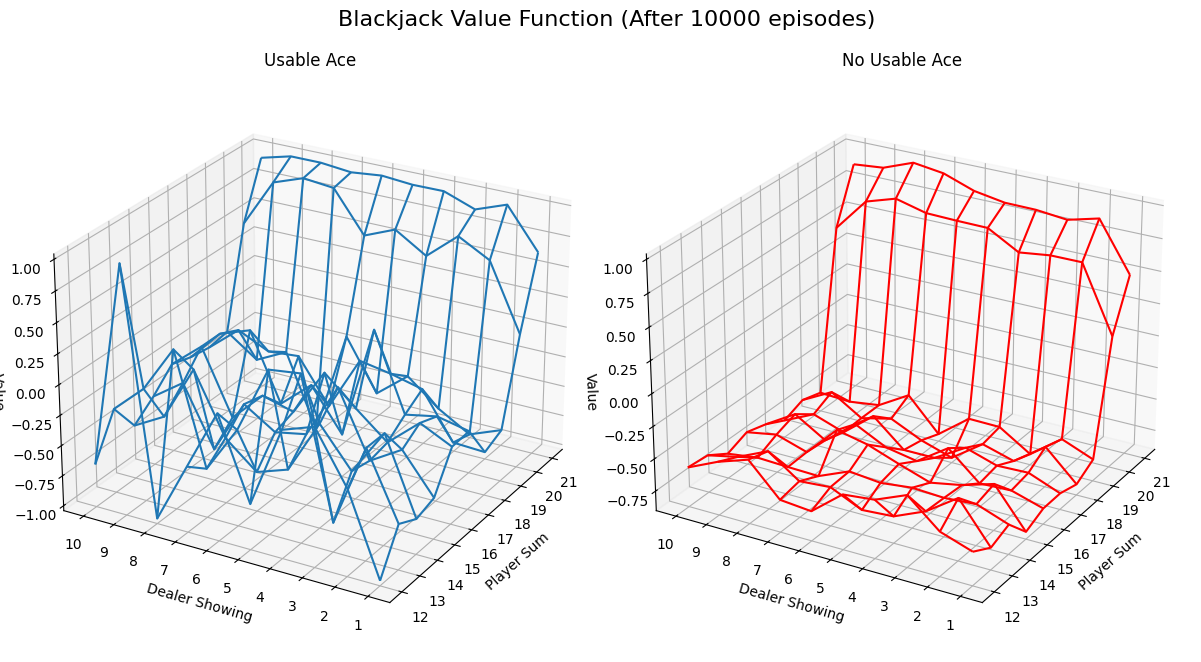

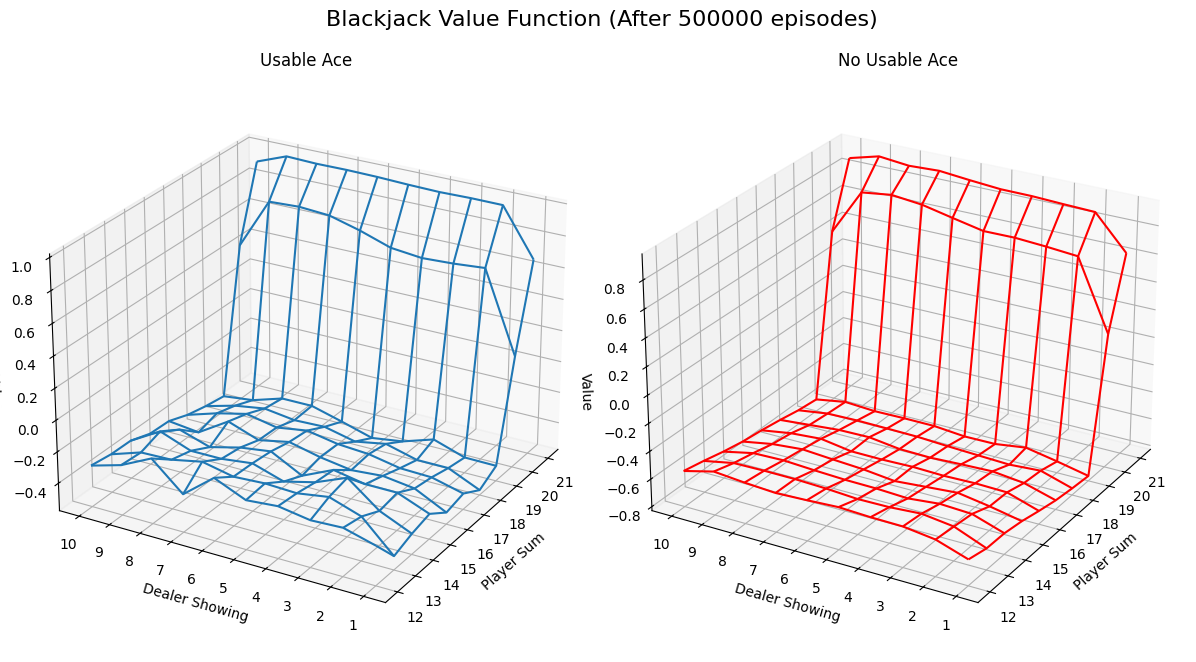

In [78]:
plot_blackjack_value_function_3d(V_10k, "Blackjack Value Function", num_episodes_1)
plot_blackjack_value_function_3d(V_500k, "Blackjack Value Function", num_episodes_2)

## (b): Implement first-visit Monte-Carlo control with exploring starts (Monte-Carlo ES in 5.3). 

Please read the Example 5.1 and reproduce the Figure 5.2

In [ ]:
def policy(state, Q, epsilon):
  """Epsilon-greedy policy derived from Q."""
  if state not in Q or random.random() < epsilon: # Explore with probability epsilon, also explore states where Q is empty
    return env.action_space.sample()
  else:
    return argmax(state, Q) # Exploit


def argmax(state,Q):
    """Returns the action that maximizes Q for a given state."""
    max_q = -float('inf')
    best_action = None
    for action in [0,1]:
        sa = (state, action)
        if sa in Q and Q[sa] > max_q:
          max_q = Q[sa]
          best_action = action
    if best_action is None:
        best_action = env.action_space.sample() # Handle cases where no action has been tried yet

    return best_action

In [ ]:
def mc_control_es(env, num_episodes, gamma=1.0, epsilon=0.1):
    """
    Monte Carlo ES (Exploring Starts) for Blackjack.
    """

    Q = {}  # Action-value function Q(s,a)
    N = {} # Keep track of how many times state-action pairs have been visited
    pi = {} # Policy pi(s) -> a

    for _ in range(num_episodes):  # Loop over episodes
        episode = []
        state = env.reset()[0]
        # Exploring Starts - choose random initial action:
        action = env.action_space.sample()
        done = False
        
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if not done:
                action = policy(state, Q, epsilon)

        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward

            # First-visit MC update:
            if (state,action) not in N:
                N[(state, action)] = 0

            N[(state, action)] += 1
            Q[(state, action)] = Q.get((state, action), 0) + (G-Q.get((state, action), 0)) / (N[(state,action)])
            pi[state] = argmax(state,Q)

    return Q, pi

In [105]:
def plot_optimal_policy(pi, title):
    """Plots the optimal policy."""
    player_sums = range(11, 22) 
    dealer_showing = range(1, 11)

    usable_ace = np.zeros((len(player_sums), len(dealer_showing)))
    no_usable_ace = np.zeros((len(player_sums), len(dealer_showing)))

    for i, player_sum in enumerate(player_sums):
        for j, showing in enumerate(dealer_showing):
            usable_ace[i, j] = pi.get((player_sum, showing, True), 0) 
            no_usable_ace[i, j] = pi.get((player_sum, showing, False), 0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title)

    axes[0].imshow(usable_ace, cmap='gray', origin='lower', extent=[1, 10, 11, 21], aspect='auto')
    axes[0].set_title("Usable Ace")
    axes[0].set_xlabel("Dealer Showing")
    axes[0].set_ylabel("Player Sum")

    axes[1].imshow(no_usable_ace, cmap='gray', origin='lower', extent=[1, 10, 11, 21], aspect='auto')
    axes[1].set_title("No Usable Ace")
    axes[1].set_xlabel("Dealer Showing")
    axes[1].set_ylabel("Player Sum")
    plt.show()

In [ ]:
""" CODE HERE YOUR IMPLEMENTATION for Q2-(b) """
env = gym.make("Blackjack-v1")
num_episodes = 500000
Q, pi = mc_control_es(env, num_episodes)

# Compute V from Q:
V = {}
for state_action, value in Q.items():
    state = state_action[0]
    if state not in V:
        V[state] = -float('inf') # Initialize to negative infinity so first value becomes the max
    V[state] = max(V[state], value) # Get the highest Q(s, a) value for each state to determine V(s)

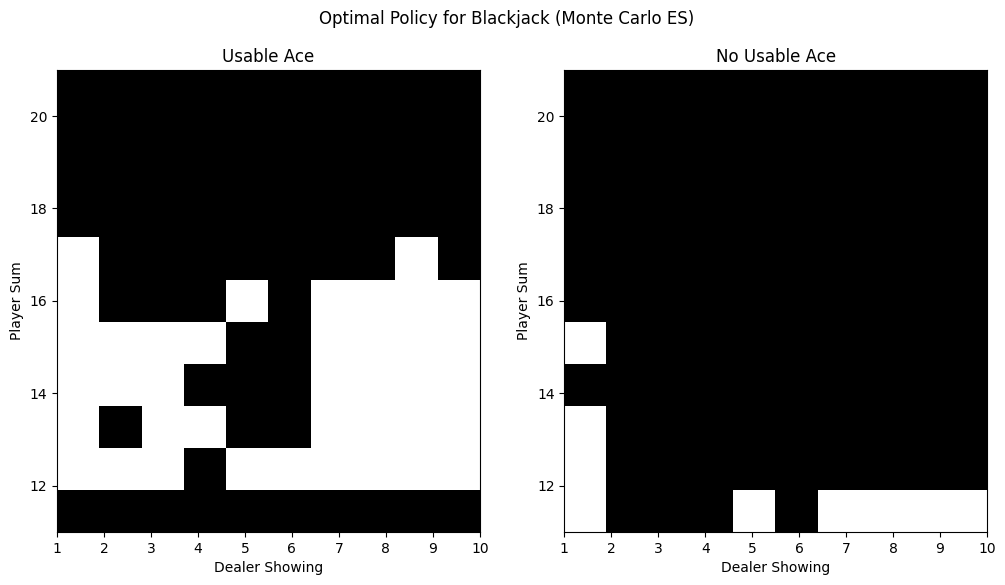

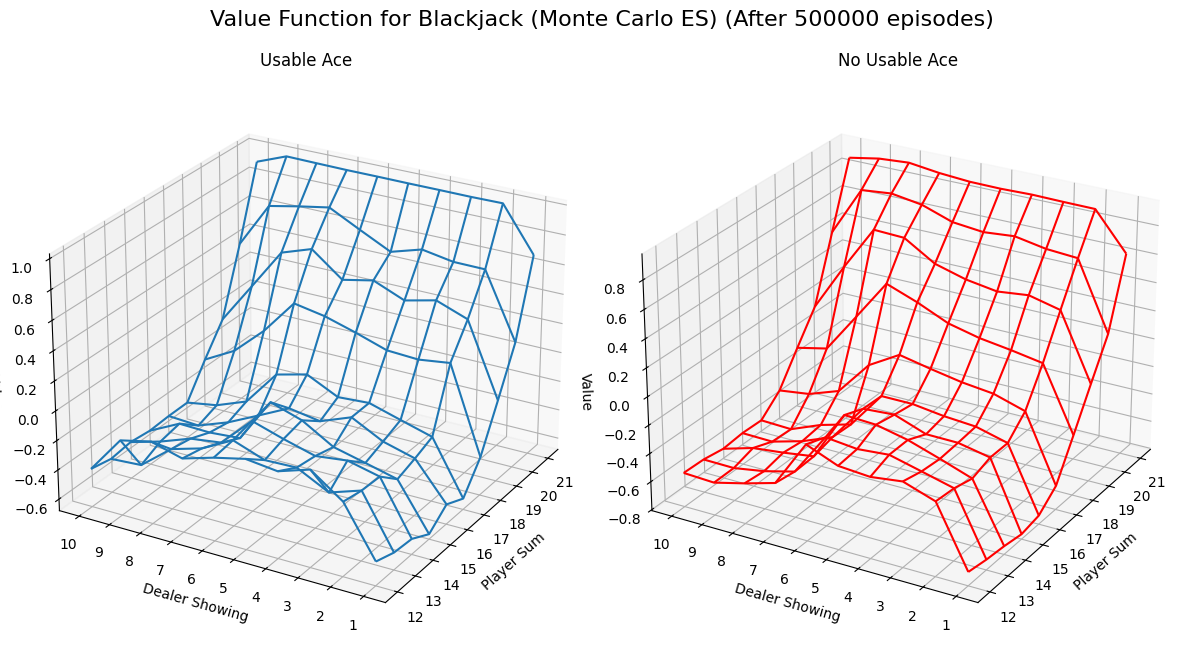

In [106]:
plot_optimal_policy(pi, "Optimal Policy for Blackjack (Monte Carlo ES)")
plot_blackjack_value_function_3d(V, "Value Function for Blackjack (Monte Carlo ES)", num_episodes)

# Q3: Four Rooms, re-visited

In [22]:
"""DO NOT CHANGE"""
class FourRooms(object):
    def __init__(self):
        # define the four room as a 2-D array for easy state space reference and visualization
        # 0 represents an empty cell; 1 represents a wall cell
        self.four_room_space = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # find the positions for all empty cells
        # note that: the origin for a 2-D numpy array is located at top-left while the origin for the FourRooms is at
        # the bottom-left. The following codes performs the re-projection.
        empty_cells = np.where(self.four_room_space == 0.0)
        self.state_space = [[col, 10 - row] for row, col in zip(empty_cells[0], empty_cells[1])]

        # define the action space
        self.action_space = {'LEFT': np.array([-1, 0]),
                             'RIGHT': np.array([1, 0]),
                             'DOWN': np.array([0, -1]),
                             'UP': np.array([0, 1])}

        # define the start state
        self.start_state = [0, 0]

        # define the goal state
        self.goal_state = [10, 10]

        # maximal time steps
        self.max_time_steps = 459

        # track the time step
        self.t = 0

    def reset(self):
        """
        Reset the agent's state to the start state [0, 0]
        Return both the start state and reward
        """
        # reset the agent state to be [0, 0]
        state = self.start_state
        # reset the reward to be 0
        reward = 0
        # reset the termination flag
        done = False
        # reset the time step tracker
        self.t = 0
        return state, reward, done

    def step(self, state, act):
        """
        Args:
            state: a list variable containing x, y integer coordinates. (i.e., [1, 1]).
            act: a string variable (i.e., "UP"). All feasible values are ["UP", "DOWN", "LEFT", "RIGHT"].
        Output args:
            next_state: a list variable containing x, y integer coordinates (i.e., [1, 1])
            reward: an integer. it can be either 0 or 1.
        """
        # Increase the time step
        self.t += 1

        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if act == "LEFT" or act == "RIGHT":
                act = np.random.choice(["UP", "DOWN"], 1)[0]
            else:
                act = np.random.choice(["RIGHT", "LEFT"], 1)[0]

        # Compute the next state
        next_state = self.take_action(state, act)

        # Compute the reward
        reward = 1.0 if next_state == [10, 10] else 0.0

        # Check the termination
        # If the agent reaches the goal, reward = 1, done = True
        # If the time steps reaches the maximal number, reward = 0, done = True.
        if next_state == [10, 10] or self.t == self.max_time_steps:
            done = True
        else:
            done = False

        return next_state, reward, done

    def take_action(self, state, act):
        """
        Input args:
            state (list): a list variable containing x, y integer coordinates. (i.e., [1, 1]).
            act (string): a string variable (i.e., "UP"). All feasible values are ["UP", "DOWN", "LEFT", "RIGHT"].
        Output args:
            next_state (list): a list variable containing x, y integer coordinates (i.e., [1, 1])
        """
        state = np.array(state)
        next_state = state + self.action_space[act]
        return next_state.tolist() if next_state.tolist() in self.state_space else state.tolist()

## (a): Implement first-visit Monte-Carlo control with a epsilon-greedy policy

In [ ]:
def argmax(state, Q):
    """Return the action with the highest Q-value for a given state."""
    actions = Q[state]
    max_value = max(actions.values())
    max_actions = [action for action, value in actions.items() if value == max_value]
    return random.choice(max_actions)

In [ ]:
def epsilon_greedy_policy(env, state, Q, epsilon):
    """Epsilon-greedy policy."""
    state = tuple(state)  # Convert state to tuple
    if state not in Q or random.random() < epsilon:  # Explore with probability epsilon, also explore states where Q is empty
        return np.random.choice(list(env.action_space.keys()))
    else:
        return argmax(state, Q)  # Exploit

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

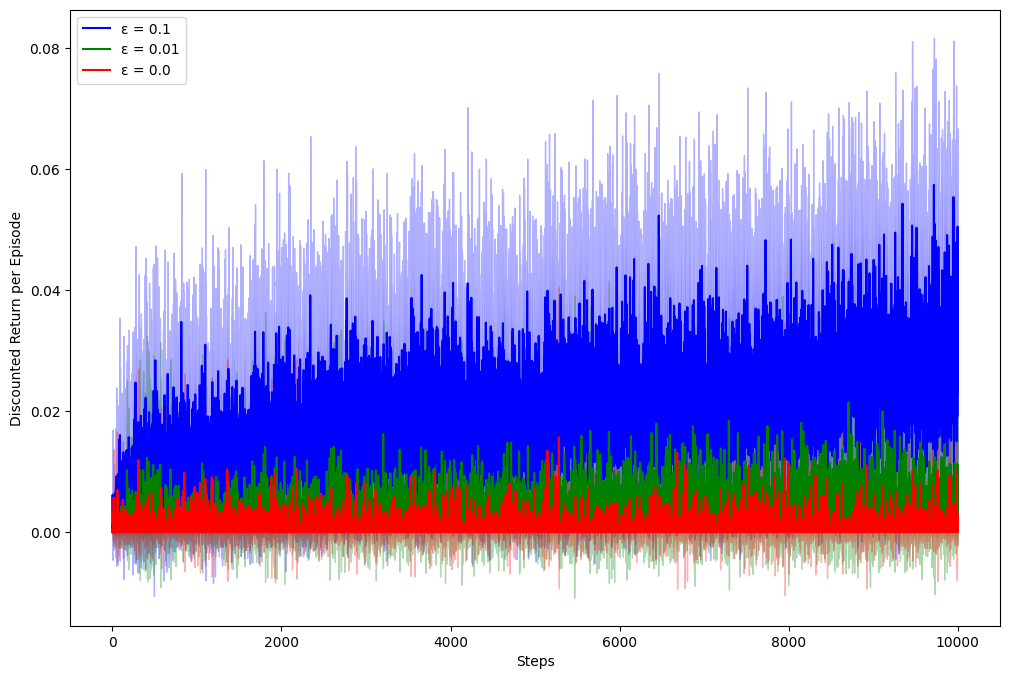

In [31]:
def run_mc_control(epsilon, gamma, num_episodes, num_trials):
    """
    Run Monte Carlo control with epsilon-greedy policy.
    """
    all_returns = []  # Store returns for each trial

    for _ in tqdm(range(num_trials), desc="Trials"):
        Q = {}  # Initialize Q(s,a)
        returns = {}  # Initialize returns
        policy = {}  # Initialize policy

        for s in env.state_space:
            s = tuple(s)  # Convert state to tuple
            Q[s] = {}
            returns[s] = {}
            policy[s] = {}
            for a in env.action_space:
                Q[s][a] = 0.0
                returns[s][a] = []
                policy[s][a] = 1.0 / len(env.action_space)

        episode_returns = []

        for _ in tqdm(range(num_episodes), desc="Episodes"):
            state, reward, done = env.reset()
            state = tuple(state)  # Convert state to tuple
            episode = []

            while not done:
                action = epsilon_greedy_policy(env, state, Q, epsilon)
                next_state, reward, done = env.step(state, action)
                next_state = tuple(next_state)  # Convert next_state to tuple
                episode.append((state, action, reward))
                state = next_state

            G = 0
            first_visit = set()
            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                state = tuple(state)  # Convert state to tuple
                G = gamma * G + reward

                if (state, action) not in first_visit:
                    first_visit.add((state, action))
                    if state not in returns:
                        returns[state] = {}
                    if action not in returns[state]:
                        returns[state][action] = []
                    returns[state][action].append(G)
                    Q[state][action] = np.mean(returns[state][action])

            episode_returns.append(G)

            for s in policy.keys():
                policy[s] = argmax(s, Q)

        all_returns.append(episode_returns)

    return all_returns

env = FourRooms()

# Parameters
gamma = 0.9  # Discount factor
num_trials = 10  # Number of trials
num_episodes = int(1e4)  # Number of episodes per trial

# ε values to test
epsilon_values = [0.1, 0.01, 0.0]
colors = ['blue', 'green', 'red']

all_returns = []
all_legends = []

for epsilon, color in zip(epsilon_values, colors):
    returns = run_mc_control(epsilon, gamma, num_episodes, num_trials)
    all_returns.append(np.array(returns))
    all_legends.append(f"ε = {epsilon}")

# Plot all curves on the same graph
plot_curves(all_returns, all_legends, colors, "Discounted Return per Episode")

## Q5: Racktrack

Please note, we provde you with the implementation of the two Racetrack domains in the Figure 5.5.

In [52]:
# Define the Racetrack domain 1
racetrack_v1_arr = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]])

racetrack_v2_arr = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

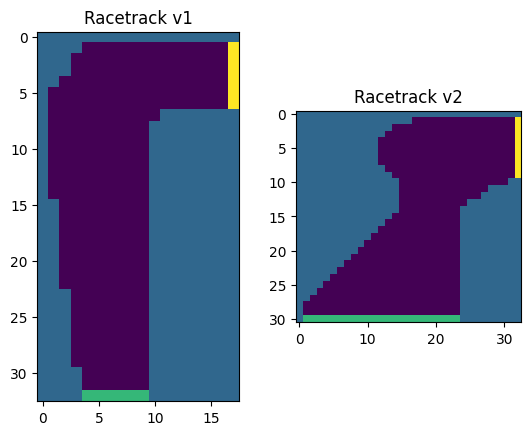

In [33]:
fig, arr = plt.subplots(1, 2)
arr[0].set_title("Racetrack v1")
arr[0].imshow(racetrack_v1_arr)
arr[1].set_title("Racetrack v2")
arr[1].imshow(racetrack_v2_arr)
plt.show()

In [51]:
"""Implementation of the Racetrack environment. Do not change"""
class Racetrack(object):
    def __init__(self, version):
        # Load the pre-defined the domain having the following representation
        #   - 1: track cell
        #   - 0: empty cell
        #   - 2: empty cell on the start line
        #   - 3: empty cell on the finish line
        if version == "v1":
            self.domain_arr = racetrack_v1_arr.copy()
        else:
            self.domain_arr = racetrack_v2_arr.copy()

        # domain size
        self.height, self.width = self.domain_arr.shape

        # State space consists of:
        # Agent location
        self.empty_cell_locs = self.render_cell_locations(val=0.0)
        self.track_cell_locs = self.render_cell_locations(val=1.0)
        self.start_cell_locs = self.render_cell_locations(val=2.0)
        self.finish_cell_locs = self.render_cell_locations(val=3.0)

        # Action space
        self.action_space = [[-1, -1], [-1, 0], [-1, 1],
                             [0, -1], [0, 0], [0, 1],
                             [1, -1], [1, 0], [1, 1]]

        # construct the state space
        self.state_space = []
        for loc in self.start_cell_locs + self.empty_cell_locs + self.finish_cell_locs:
            for i in range(5):
                for j in range(5):
                    self.state_space.append(loc + [i, j])

        # track the agent's location
        self.state = None
        self.action = None
        self.t = None

    def reset(self):
        # randomly select one cell from the start line
        start_loc = random.sample(self.start_cell_locs, 1)[0]
        # reset the velocity to be zero for both x and y directions
        start_vel = [0, 0]
        # the state is a combination of location and velocity
        # for example: [loc_x, loc_y, vel_x, vel_y]
        state = start_loc + start_vel
        # reward
        reward = None
        # done
        done = False
        # track agent's location
        self.state = tuple(state)
        self.t = 0
        return state, reward, done

    def step(self, state, action):
        """
        Args:
            state (list): a list variable consists of agent's location + agent's current velocity. e.g., [x, y, v_x, v_y]
            action (list): a list variable consists of agent's velocity increments. e.g., [increments_v_x, increments_v_y]
        """
        # reward is -1 for every time step until the agent passes the finish line
        reward = -1
        self.t += 1
        
        # with the probability = 0.1, set action = [0, 0]
        if np.random.random() < 0.1:
            action = [0, 0]

        # update the velocity components
        # note that, both velocity is discrete and constraint within [0, 4]
        next_vel_x = np.clip(state[2] + action[0], a_min=0, a_max=4)
        next_vel_y = np.clip(state[3] + action[1], a_min=0, a_max=4)
        next_state_vel = [next_vel_x, next_vel_y]

        # only the cells on the start line can have both 0 velocities
        if next_state_vel == [0, 0]:
            if state not in self.start_cell_locs:
                # non-zero for velocities
                if state[2] == 0 and state[3] != 0:
                    next_state_vel = [0, 1]
                if state[2] != 0 and state[3] == 0:
                    next_state_vel = [1, 0]
                if state[2] != 0 and state[3] != 0:
                    non_zero_idx = random.sample([0, 1], 1)[0]
                    next_state_vel[non_zero_idx] = 1

        # update the next state location based on the updated velocities
        next_state_loc = [np.clip(state[0] + next_state_vel[0], a_min=0, a_max=self.width-1),
                          np.clip(state[1] + next_state_vel[1], a_min=0, a_max=self.height-1)]

        # check whether the agent hits the track
        if next_state_loc in self.track_cell_locs:
            # move back to the start line
            next_state_loc = random.sample(self.start_cell_locs, 1)[0]
            # reduce velocity to be 0s
            next_state_vel = [0, 0]
            # episode continue
            done = False
            # next state
            next_state = next_state_loc + next_state_vel
            return next_state, reward, done

        # check whether the agent pass the finish line
        if next_state_loc in self.finish_cell_locs:
            next_state = next_state_loc + next_state_vel
            done = True
            return next_state, 0, done

        # otherwise combine the next state
        next_state = next_state_loc + next_state_vel
        # termination
        done = False

        # track the agent's state
        self.state = tuple(next_state)
        self.action = action
        return next_state, reward, done

    def render_cell_locations(self, val):
        row_loc_indices, col_loc_indices = np.where(self.domain_arr == val)
        cell_locations = [[c, (self.height-1) - r] for r, c in zip(row_loc_indices, col_loc_indices)]
        return cell_locations

    def render(self):
        plt.clf()
        plt.title(f"s = {self.state}, a = {self.action}")
        plot_arr = self.domain_arr.copy()
        plot_arr[(self.height - 1) - self.state[1], self.state[0]] = 4
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.01)

## (a): Implement first-visit Monte-Carlo control with a epsilon-greedy policy (epsilon = 0.1)
    - Plot the learning curves for the two tracks.
    - Use running trials number = 10 and episodes number = 2000

In [53]:
def argmax(state, Q):
    """Return the action with the highest Q-value for a given state."""
    actions = Q.get(state, {})  # Get available actions for the state (or empty dict if state not seen)
    
    if not actions:  # If no actions have been tried for this state yet
        return random.choice(env.action_space)  # Choose a random action to explore

    max_value = -float('inf')  # Initialize max value to negative infinity
    max_actions = []          # Initialize list to store actions with max value

    for action, value in actions.items():  # Iterate through available actions and their values
        if value > max_value:             # If the current value is greater than the current max
            max_value = value             # Update max value
            max_actions = [action]      # Store the current action as the only max action so far
        elif value == max_value:            # If the current value equals the current max
            max_actions.append(action)     # Add the current action to the list of max actions

    # If max_actions is not empty (at least one action with max value found), choose randomly among them
    # Otherwise (no max actions found, which should be rare), choose a random action
    return random.choice(max_actions) if max_actions else random.choice(env.action_space)

In [54]:
def epsilon_greedy_policy(env, state, Q, epsilon):
    """Epsilon-greedy policy."""
    if random.random() < epsilon:  # Explore: with probability epsilon
        return random.choice(env.action_space)  # Choose a random action
    else:  # Exploit: with probability 1 - epsilon
        return argmax(state, Q)    # Choose the action with the highest Q-value for the current state

In [55]:
def run_mc_control(env, epsilon, gamma, num_episodes, num_trials, off_policy=False):
    """Run Monte Carlo control with epsilon-greedy policy."""
    all_returns = []

    for _ in tqdm(range(num_trials), desc="Trials"):
        Q = {}              # Initialize Q-values (state-action values)
        C = {}              # Initialize cumulative weights for off-policy (weighted importance sampling)
        returns = {}         # Store returns for each state-action pair (on-policy)
        episode_returns = [] # Store returns for each episode

        for _ in tqdm(range(num_episodes), desc="Episodes"):
            state, reward, done = env.reset() # Start a new episode
            episode = []                      # Store the episode's trajectory (s, a, r)

            while not done: # Generate an episode
                action = epsilon_greedy_policy(env, tuple(state), Q, epsilon if not off_policy else 0.1) # epsilon of behaviour is 0.1 
                next_state, reward, done = env.step(state, action)
                episode.append((tuple(state), tuple(action), reward)) # append to trajectory
                state = next_state

            G = 0.0   # Initialize return
            W = 1.0   # Initialize importance sampling ratio

            for t in reversed(range(len(episode))): # Loop through episode steps in reverse
                state, action, reward = episode[t]
                G = gamma * G + reward # calculate discounted return

                if off_policy: # Off-policy updates (weighted importance sampling)
                    if state not in C:
                        C[state] = {}
                    if action not in C[state]:
                        C[state][action] = 0

                    C[state][action] += W

                    if state not in Q:
                        Q[state] = {}
                    if action not in Q[state]:
                        Q[state][action] = 0.0

                    Q[state][action] += (W / C[state][action]) * (G - Q[state][action]) # Update Q-value incrementally

                    if action != argmax(state, Q):
                        break

                    # Calculate probability of behavior policy taking the action
                    if state not in Q:
                         prob_behavior = (epsilon / len(env.action_space))
                    elif action not in Q[state]:
                         prob_behavior = (epsilon / len(env.action_space))
                    elif action != argmax(state, Q):
                         prob_behavior = (epsilon / len(env.action_space))
                    else:
                         prob_behavior = 1 - epsilon + (epsilon / len(env.action_space))
                    
                    W = W / prob_behavior # Update importance sampling ratio

                else:  # On-policy updates (first-visit MC)
                    if state not in returns:
                        returns[state] = {}
                    if action not in returns[state]:
                        returns[state][action] = []

                    returns[state][action].append(G)
                    if state not in Q:
                        Q[state] = {}
                    if action not in Q[state]:
                        Q[state][action] = 0.0
                    Q[state][action] = np.mean(returns[state][action]) # Average returns to get Q-value


            episode_returns.append(G) # Store episode return

        all_returns.append(episode_returns) # Append to returns from all trials
    return all_returns

# Parts (a) & (b)

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

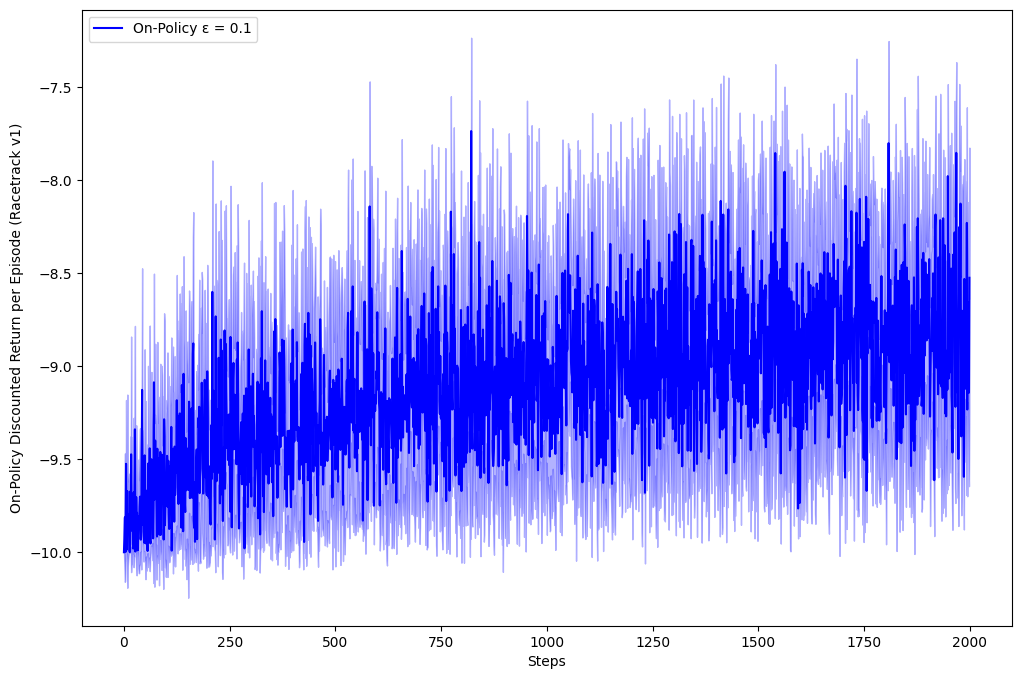

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

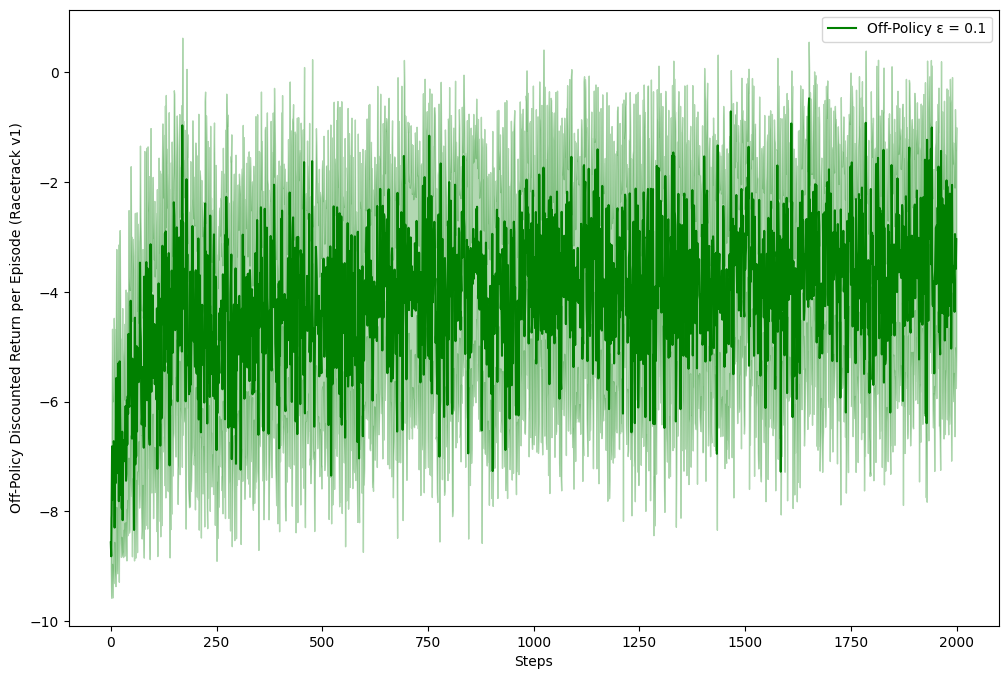

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

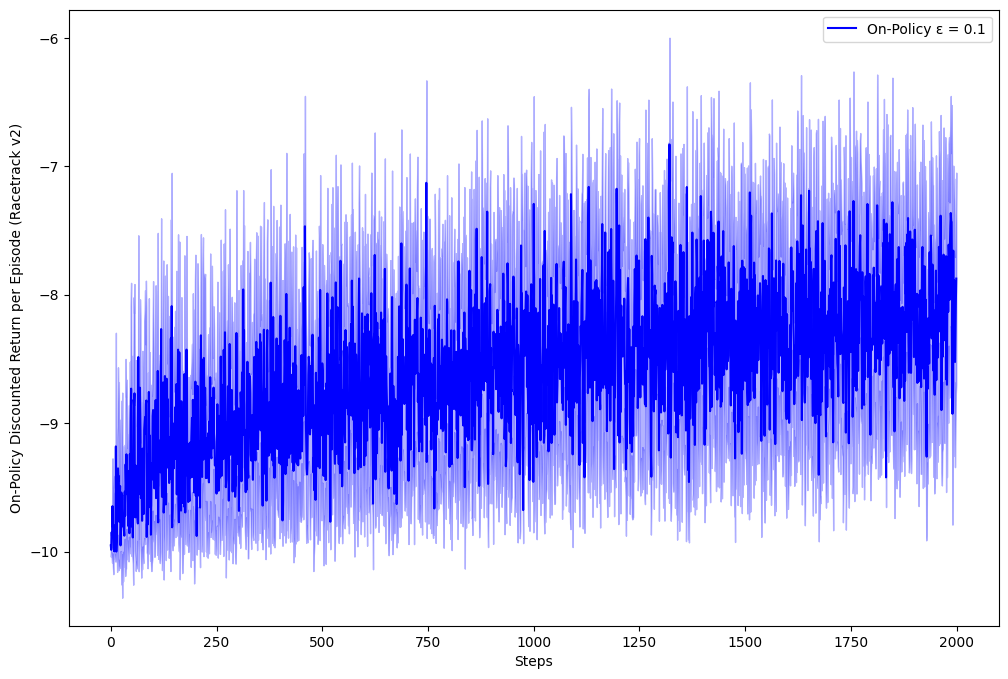

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

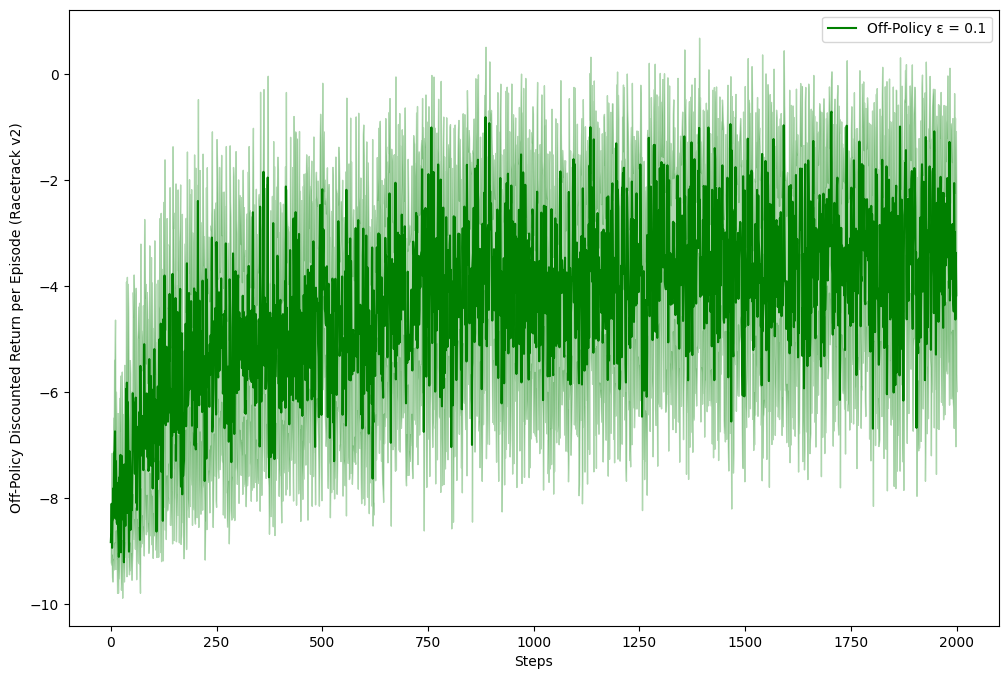

In [56]:
versions = ["v1", "v2"]
for version in versions:
    env = Racetrack(version)

    gamma = 0.9
    num_trials = 10
    num_episodes = 2000
    epsilon = 0.1

    # (a) On-policy MC control
    """ CODE HERE YOUR IMPLEMENTATION for Q5-(a) """
    # Implement here and use the plotting function above to plot the learning curve     
    on_policy_returns = run_mc_control(env, epsilon, gamma, num_episodes, num_trials)
    plot_curves([np.array(on_policy_returns)], [f"On-Policy ε = {epsilon}"], ['blue'], f"On-Policy Discounted Return per Episode (Racetrack {version})")

    # (b) Off-policy MC control
    """ CODE HERE YOUR IMPLEMENTATION for Q5-(b) """
    # Implement here and use the plotting function above to plot the learning curve 
    off_policy_returns = run_mc_control(env, epsilon, gamma, num_episodes, num_trials, off_policy=True)
    plot_curves([np.array(off_policy_returns)], [f"Off-Policy ε = {epsilon}"], ['green'], f"Off-Policy Discounted Return per Episode (Racetrack {version})")